In [1]:
!pip show torch torchvision

Name: torch
Version: 2.2.2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: captum, torchaudio, torchtext, torchvision
---
Name: torchvision
Version: 0.17.2
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages
Requires: numpy, pillow, torch
Required-by: 


In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 51.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 151.4 MB/s eta 0:00:00


In [25]:
import boto3
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from io import BytesIO

class S3ImageDataset(Dataset):
    def __init__(self, bucket_name, prefix, transform=None):
        """
        S3 버킷에서 이미지를 로드하는 PyTorch 데이터셋 클래스.

        Args:
        - bucket_name: S3 버킷 이름.
        - prefix: S3 폴더 경로 (e.g., 'your-folder/train/').
        - transform: 이미지 전처리를 위한 torchvision.transforms 객체.
        """
        self.s3 = boto3.client('s3')
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.transform = transform
        self.files = self._list_files()

    def _list_files(self):
        """S3 폴더 내 파일 리스트를 가져옵니다."""
        response = self.s3.list_objects_v2(Bucket=self.bucket_name, Prefix=self.prefix)
        return [content['Key'] for content in response.get('Contents', []) if not content['Key'].endswith('/')]

    def __len__(self):
        """데이터셋의 전체 이미지 수."""
        return len(self.files)

    def __getitem__(self, idx):
        """지정된 인덱스의 이미지를 가져옵니다."""
        file_key = self.files[idx]
        response = self.s3.get_object(Bucket=self.bucket_name, Key=file_key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # 이미지 열기

        if self.transform:
            image = self.transform(image)

        # 클래스 레이블 추출 (폴더 이름에서 추출)
        label = 0 if "NG/" in file_key else 1  # NG -> 0, OK -> 1

        return image, label


In [26]:
# 이미지 전처리 파이프라인 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet에 맞게 크기 조정
    transforms.ToTensor(),         # Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

# S3 데이터셋 생성
bucket_name = 'smwu-cv-team-2-s3'
train_prefix = 'preprocessed-data/origin_split/train/'  # S3 폴더 경로
train_dataset = S3ImageDataset(bucket_name=bucket_name, prefix=train_prefix, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [27]:
# 테스트 데이터 경로
test_prefix = 'preprocessed-data/origin_split/test/'

# S3에서 테스트 데이터셋 생성
test_dataset = S3ImageDataset(bucket_name=bucket_name, prefix=test_prefix, transform=transform)

# DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [28]:
val_prefix = 'preprocessed-data/origin_split/valid/'  # S3에 Validation 데이터 경로
val_dataset = S3ImageDataset(bucket_name=bucket_name, prefix=val_prefix, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/20 | Train Loss: 0.9865 | Val Loss: 6.6239
Epoch 2/20 | Train Loss: 0.7030 | Val Loss: 0.7814
Epoch 3/20 | Train Loss: 0.6760 | Val Loss: 0.6974
Epoch 4/20 | Train Loss: 0.6771 | Val Loss: 0.5577
Epoch 5/20 | Train Loss: 0.5412 | Val Loss: 1.7481
Epoch 6/20 | Train Loss: 0.5420 | Val Loss: 47.4003
Epoch 7/20 | Train Loss: 0.4931 | Val Loss: 2.1069
Epoch 8/20 | Train Loss: 0.4458 | Val Loss: 10.4763
Epoch 9/20 | Train Loss: 0.2901 | Val Loss: 0.6481
Epoch 10/20 | Train Loss: 0.2374 | Val Loss: 0.9620
Epoch 11/20 | Train Loss: 0.1891 | Val Loss: 0.2583
Epoch 12/20 | Train Loss: 0.1714 | Val Loss: 0.3123
Epoch 13/20 | Train Loss: 0.2057 | Val Loss: 0.3570
Epoch 14/20 | Train Loss: 0.2158 | Val Loss: 0.5512
Epoch 15/20 | Train Loss: 0.2953 | Val Loss: 7.0898
Epoch 16/20 | Train Loss: 0.1449 | Val Loss: 0.8604
Epoch 17/20 | Train Loss: 0.0700 | Val Loss: 0.2484
Epoch 18/20 | Train Loss: 0.0698 | Val Loss: 0.5233
Epoch 19/20 | Train Loss: 0.0654 | Val Loss: 0.2669
Epoch 20/20 | Train

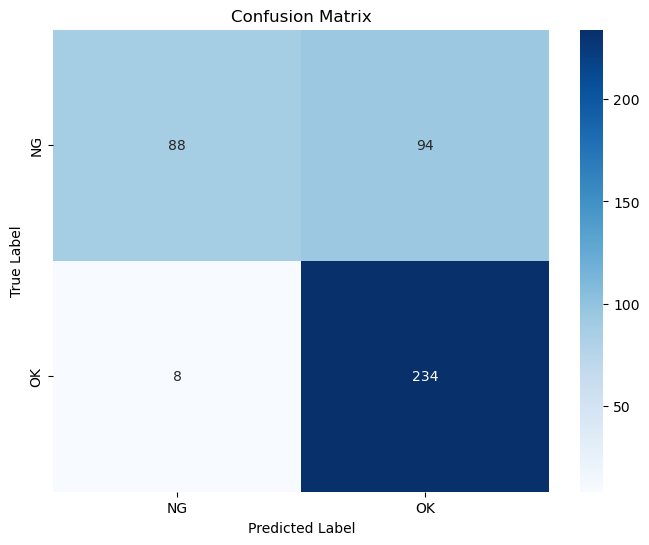

Classification Report:
              precision    recall  f1-score   support

          NG       0.92      0.48      0.63       182
          OK       0.71      0.97      0.82       242

    accuracy                           0.76       424
   macro avg       0.82      0.73      0.73       424
weighted avg       0.80      0.76      0.74       424



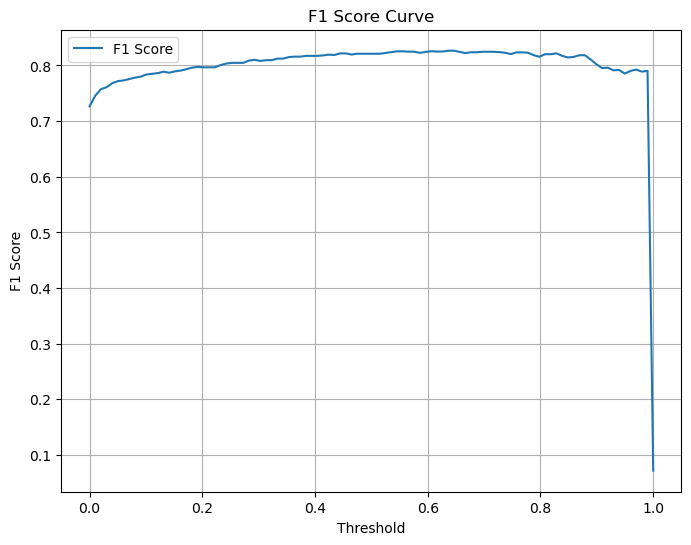

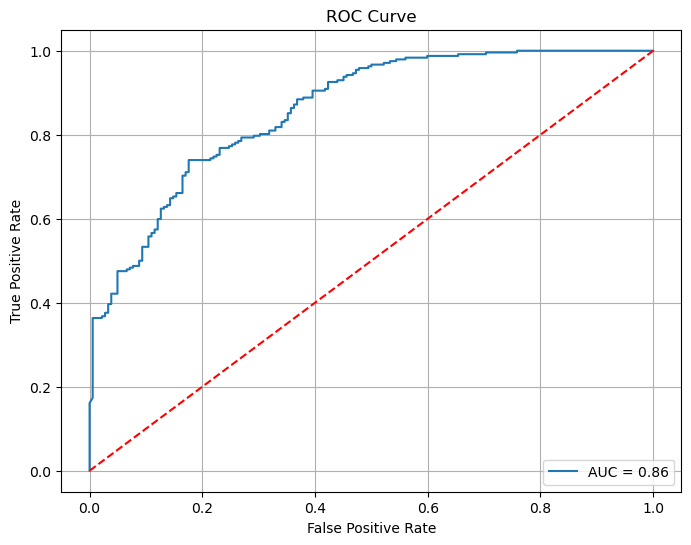

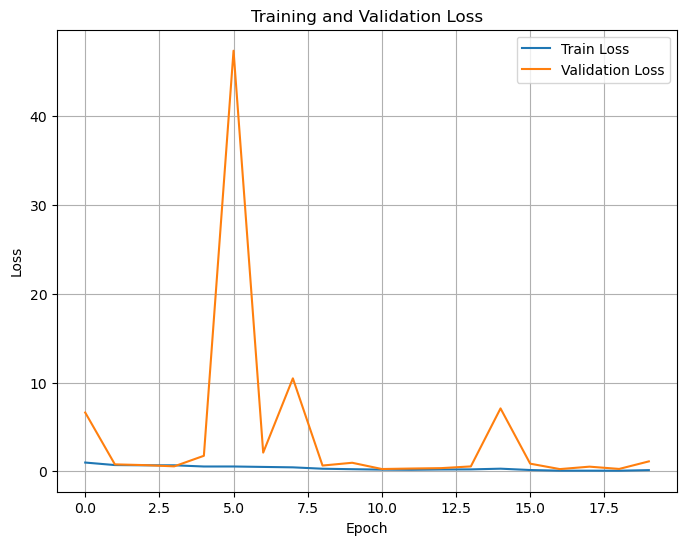

Test Accuracy: 75.94%


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

# ResNet 모델 설정
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 클래스 수: 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ConfusionMatrixEvaluator 클래스 선언 (위에서 정의한 코드 사용)
evaluator = Evaluator(model, test_loader, device)

# 학습 루프
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 에포크당 평균 학습 손실 계산
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:  # val_loader를 사용해 Validation Loss 계산
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)  # Validation Loss 평균

    # Training 및 Validation Loss 업데이트
    evaluator.update_training_loss(train_loss=avg_train_loss, val_loss=avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# 테스트 데이터 평가
evaluator.evaluate()

# Confusion Matrix 출력
evaluator.plot_confusion_matrix()

# Classification Report 출력
evaluator.print_classification_report()

# F1-Score Curve 출력
evaluator.plot_f1_score_curve()

# ROC Curve 출력
evaluator.plot_roc_curve()

# 학습 및 검증 손실 곡선 출력
evaluator.plot_training_curves()


# 정확도 출력
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader 사용
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


In [20]:
model.eval()  # 모델을 평가 모드로 설정
val_loss = 0.0
with torch.no_grad():  # Gradient 계산 비활성화
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Validation Loss 계산
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")

Validation Loss: 0.2251


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

class Evaluator:
    def __init__(self, model, test_loader, device):
        """
        Confusion Matrix 및 학습/평가 지표를 제공하는 클래스.

        Args:
        - model: PyTorch 모델.
        - test_loader: 테스트 데이터 로더.
        - device: 모델 디바이스 ('cuda' 또는 'cpu').
        """
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.y_true = []
        self.y_pred = []
        self.y_scores = []
        self.train_losses = []
        self.val_losses = []

    def evaluate(self):
        """모델 평가 - y_true, y_pred, y_scores 저장."""
        self.model.eval()
        self.y_true = []
        self.y_pred = []
        self.y_scores = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Positive class 확률
                _, predicted = torch.max(outputs, 1)
                
                self.y_true.extend(labels.cpu().numpy())
                self.y_pred.extend(predicted.cpu().numpy())
                self.y_scores.extend(probabilities.cpu().numpy())

    def plot_confusion_matrix(self):
        """Confusion Matrix 생성 및 시각화."""
        cm = confusion_matrix(self.y_true, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NG', 'OK'], yticklabels=['NG', 'OK'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    def print_classification_report(self):
        """Classification Report 출력."""
        print("Classification Report:")
        print(classification_report(self.y_true, self.y_pred, target_names=['NG', 'OK']))

    def plot_f1_score_curve(self):
        """F1-Score Curve 생성."""
        thresholds = np.linspace(0, 1, 100)
        f1_scores = []

        for threshold in thresholds:
            y_pred_threshold = (np.array(self.y_scores) >= threshold).astype(int)
            f1 = f1_score(self.y_true, y_pred_threshold)
            f1_scores.append(f1)

        plt.figure(figsize=(8, 6))
        plt.plot(thresholds, f1_scores, label="F1 Score")
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score Curve')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_roc_curve(self):
        """ROC Curve 생성."""
        fpr, tpr, _ = roc_curve(self.y_true, self.y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'r--')  # 대각선 기준선
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    def plot_training_curves(self):
        """학습 및 검증 손실 곡선 시각화."""
        plt.figure(figsize=(8, 6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()
        plt.show()

    def update_training_loss(self, train_loss, val_loss):
        """훈련 중 손실값 업데이트."""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
